<a href="https://colab.research.google.com/github/Okello-Arnold/course_correct/blob/main/Randon_Forest_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 89.0 MB/s eta 0:00:00


In [ ]:
!pip install seaborn scikit-learn pandas numpy matplotlib imbalanced-learn --quiet

Saving Diabetes_Final_Data_V2.csv to Diabetes_Final_Data_V2 (5).csv
Dataset Sample:


,age,gender,pulse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,hypertensive,family_hypertension,cardiovascular_disease,stroke,diabetic
0,42,Female,66,110,73,5.88,1.65,70.2,25.75,0,0,0,0,0,No
1,35,Female,60,125,68,5.71,1.47,42.5,19.58,0,0,0,0,0,No
2,62,Female,57,127,74,6.85,1.52,47.0,20.24,0,0,0,0,0,No
3,73,Male,55,193,112,6.28,1.63,57.4,21.72,0,0,0,0,0,No
4,68,Female,71,150,81,5.71,1.42,36.0,17.79,0,0,0,0,0,No



Class Distribution After SMOTE:
diabetic
0    4074
1    3055
Name: count, dtype: int64

Best Hyperparameters: {'class_weight': {0: 1, 1: 6}, 'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 150}

Test Accuracy: 0.9026
ROC AUC Score: 0.8375

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1019
           1       0.31      0.43      0.36        69

    accuracy                           0.90      1088
   macro avg       0.63      0.68      0.65      1088
weighted avg       0.92      0.90      0.91      1088



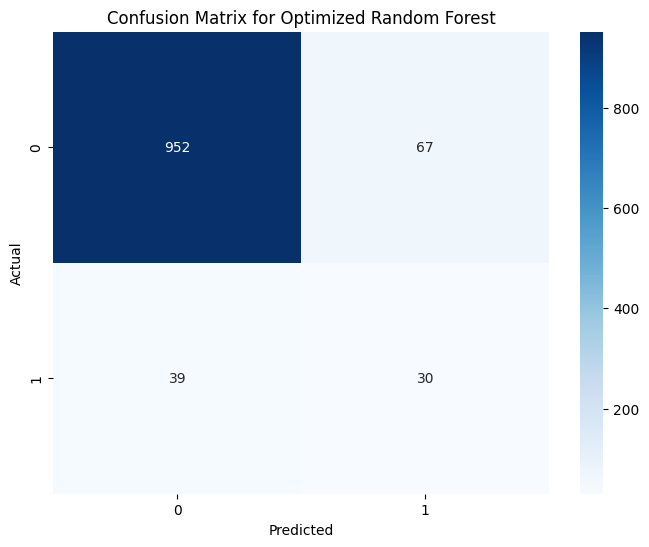

In [ ]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Load dataset
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Display the first few rows of the dataset
print("Dataset Sample:")
display(df.head())

# Convert categorical variables to numeric
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})
df['diabetic'] = df['diabetic'].str.lower().map({'yes': 1, 'no': 0})

# Drop any remaining missing values
df.dropna(inplace=True)

# Define features and target variable
features = ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'glucose',
            'height', 'weight', 'bmi', 'family_diabetes', 'hypertensive',
            'family_hypertension', 'cardiovascular_disease', 'stroke']
target = 'diabetic'

X = df[features]
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data (stratify to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE with higher oversampling ratio (75% to increase diabetic representation)
smote = SMOTE(sampling_strategy=0.75, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass Distribution After SMOTE:")
print(y_train_resampled.value_counts())

# Use Recursive Feature Elimination (RFE) for Feature Selection
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFE(rf_base, n_features_to_select=8)  # Selecting top 8 features
X_train_resampled = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test = selector.transform(X_test)

# Define Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 6}]  # Further prioritizing diabetics
}

# Run Grid Search for Best Hyperparameters
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_rf = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Train Final Model with Best Parameters
best_rf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities (needed for threshold tuning)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Adjust classification threshold (set to 0.25 to increase diabetic recall)
threshold = 0.85
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate performance metrics
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix for Optimized Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
